In [33]:
import sys

import statsbomb as sb
from tqdm import tqdm
import re
import random
import numpy as np
from math import sqrt
from collections import defaultdict
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from glob import glob
import json

import matplotlib.pyplot as plt
from matplotlib import collections as mc

from scipy.spatial import distance
from math import pi

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pickle

In [2]:
X = 120
Y = 90
def toCell(n=(8, 6), coords=(10.0, 10.0), normalized=False): # n = (8, 6) => 15
#     n = sqrt(X * Y / n)
#     nx = X / n[0]
#     ny = Y / n[1]
    nx, ny = n[0], n[1]
    nx = int(nx) 
    ny = int(ny)
    res = np.zeros((ny, nx))
    if normalized:
        coords = (coords[0] * X / nx, coords[1] * Y / ny)
    cury = int(coords[1] // (Y / ny))
    curx = int(coords[0] // (X / nx))
    cury = ny-1 if cury == ny else cury #
    curx = nx-1 if curx == nx else curx #
    res[cury][curx] = 1
    return res

def preproc(df, play_patterns, height_patterns, data_col, labels_col, types_col, X, Y, norm=True):
    df.under_pressure = df.under_pressure.apply(lambda x: 1 if x else 0)
    df.play_pattern = df.play_pattern.apply(lambda x: play_patterns[x])
    df.height = df.height.apply(lambda x: height_patterns[x] / len(height_patterns))
    df.pass_backheel = df.pass_backheel.apply(lambda x: 1 if x else 0)
    df.miscommunication = df.miscommunication.apply(lambda x: 1 if x else 0)
    df.through_ball = df.through_ball.apply(lambda x: 1 if x else 0)
    df.cross = df.cross.apply(lambda x: 1 if x else 0)
    df.cut_back = df.cut_back.apply(lambda x: 1 if x else 0)
    df.switch = df.switch.apply(lambda x: 1 if x else 0)
    df.shot_assist = df.shot_assist.apply(lambda x: 1 if x else 0)
    df.goal_assist = df.goal_assist.apply(lambda x: 1 if x else 0)
    if norm:
        df.start_location_x = df.start_location_x.apply(lambda x: x / X)
        df.start_location_y = df.start_location_x.apply(lambda x: x / Y)
        df.end_location_x = df.start_location_x.apply(lambda x: x / X)
        df.end_location_y = df.start_location_x.apply(lambda x: x / Y)
        df.length = df.length.apply(lambda x: x / X)
    return df[data_col], df[labels_col], df[types_col]

In [3]:
columns = ['timestamp', 'possession_team', 'player', 'play_pattern', 'duration', 
           'under_pressure', 'length', 'angle', 'height', 'pass_backheel', 
           'miscommunication', 'through_ball', 'cross', 'cut_back', 'switch', 'shot_assist', 
           'goal_assist', 'start_location_x', 'start_location_y', 'end_location_x', 
           'end_location_y']

data_col = ['start_location_x', 'start_location_y', 
            'end_location_x', 'end_location_y',
            'height', 'length', 'angle']

players_col = ['player']
types_col = ['play_pattern']
play_patterns = {'Regular Play': 0, 'From Corner': 1, 'From Free Kick': 2, 'From Throw In': 3, 
                 'Other': 4, 'From Counter': 5, 'From Goal Kick': 6, 'From Keeper': 7, 
                 'From Kick Off': 8}
height_patterns = {'Ground Pass': 0, 'Low Pass': 1, 'High Pass': 2}

In [4]:
matches_by_seasons = defaultdict(list)
for some_matches in tqdm(glob('matches/*/*.json')):
    with open(some_matches, 'r') as f:
        data = json.load(f)
    for match in data:
        if match['competition']['competition_name'] == 'La Liga':
            matches_by_seasons[match['season']['season_name']].append(match['match_id'])
matches_by_seasons = sorted(matches_by_seasons.items(), key=lambda x: x[0])

100%|██████████| 17/17 [00:00<00:00, 936.49it/s]


In [5]:
seasons = [key for key, val in matches_by_seasons]
seasons

['2004/2005',
 '2005/2006',
 '2006/2007',
 '2007/2008',
 '2008/2009',
 '2009/2010',
 '2010/2011',
 '2011/2012',
 '2012/2013',
 '2013/2014',
 '2014/2015',
 '2015/2016']

In [6]:
# barca_players = []
# for i, season in enumerate(tqdm(seasons)):
#     for match_id in matches_by_seasons[i][1]:
#         match = sb.Events(event_id=match_id)
#         j = 0 if match.data[0]['possession_team']['name'] == 'Barcelona' else 1
#         players = [player['player']['name'] for player in match.data[j]['tactics']['lineup'] 
#                    if player['player']['name'] not in barca_players]
#         barca_players.extend(players)
with open('barca_players.pickle', 'rb') as f:
    barca_players = pickle.load(f)

<BarContainer object of 12 artists>

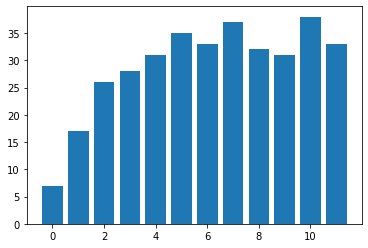

In [7]:
plt.bar(range(len(matches_by_seasons)), [len(val) for key, val in matches_by_seasons])

In [8]:
player2idx = {player: i for i, player in enumerate(barca_players)}
idx2player = {val: key for key, val in player2idx.items()}

In [9]:
EMBEDDING_DIM = 16
VOCABULARY_SIZE = len(barca_players)
INPUT_SIZE = len(data_col)

In [10]:
def create_data(events):
    data = pd.DataFrame(columns=data_col)
    players = pd.DataFrame(columns=players_col)
    types = pd.DataFrame(columns=types_col)

    for match_id in events: # matches_by_seasons[-1][1]):
        match = sb.Events(event_id=match_id)
        df = match.get_dataframe(event_type='pass')[columns]
        cur_data, cur_players, cur_types = preproc(df, play_patterns=play_patterns, 
                                                   height_patterns=height_patterns, data_col=data_col, 
                                                   labels_col=players_col, types_col=types_col, X=X, Y=Y)
        data = data.append(cur_data, ignore_index=True)
        players = players.append(cur_players, ignore_index=True)
        types = types.append(cur_types, ignore_index=True)

    data = data.sample(frac=1)
    ind = data.index
    players = players.reindex(ind)
    types = types.reindex(ind)

    data = data.reset_index(drop=True)
    players = players.reset_index(drop=True)
    types = types.reset_index(drop=True)
    return data, players

In [11]:
def afterproc_data(data, players):
    criterion = players.player.map(lambda x: x in barca_players)

    data = data[criterion].reset_index(drop=True)
    players = players[criterion].reset_index(drop=True)
#     types = types[criterion].reset_index(drop=True)
    return data, players

In [12]:
class Pass2Vec(nn.Module):

    def __init__(self, embedding_dim, input_size, vocabulary_size):
        super(Pass2Vec, self).__init__()
        
        self.fc1 = nn.Linear(input_size, embedding_dim)
        
        self.fc2 = nn.Linear(embedding_dim, vocabulary_size)

    def forward(self, x):
        z1 = self.fc1(x)
        z2 = self.fc2(z1)
        return z2 

In [13]:
def train(model, data, players, n_epoches):
    avg_loss = []

    for epoch in range(n_epoches):

        running_loss = []
        for i in range(data.index.size-1):
            batch = torch.tensor(data[i:i+1].values.astype('float64')).type('torch.FloatTensor')
            targets = torch.tensor([player2idx[players[i:i+1].values[0][0]]]).type('torch.LongTensor')

            model.zero_grad()

            tag_scores = model(batch)

            loss = loss_function(tag_scores, targets)
            loss.backward()
            optimizer.step()

            for p in model.parameters(): # making weights non-negative
                p.data.clamp_(0)

            running_loss.append(loss.item())

        avg_loss.append(round(sum(running_loss) / len(running_loss), 4))
#         print('epo: {0}, loss: {1}'.format(epoch, avg_loss[-1]))
    return avg_loss

In [14]:
def plot_loss(avg_loss):
    Xc, Yc = range(len(avg_loss)), avg_loss

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(Xc, Yc, label='pass prediction')
    ax.set_title('n_epoch')
    ax.legend(loc='upper left')
    ax.set_ylabel('loss')
    fig.tight_layout()

    plt.show()

In [15]:
def idx2tensor(idx, n):
    x = torch.zeros(n).float()
    x[idx] = 1.0
    return x

In [16]:
class Embedding(object):
    def __init__(self, model, players_list, player2idx):
        with torch.no_grad():
            self.weight = model.fc2.weight.detach().numpy()
        self.emb = {}
        self.create_embedding(players_list, player2idx)
        
    def create_embedding(self, players_list, player2idx):
        with torch.no_grad():
            for player in players_list:
                self.emb[player] = idx2tensor(player2idx[player], VOCABULARY_SIZE).numpy() @ self.weight
            
    def __getitem__(self, key):
        return self.emb[key]
    
    def dist(self, a, b, vec=False):
        if vec:
            return 1.0 - distance.cosine(a, b)
        else:
            return 1.0 - distance.cosine(self.emb[a], self.emb[b])
    
    def most_common(self, a, n=10, vec=False):
        dd = {key: self.dist(a, val, vec=True) for key, val in self.emb.items()} if vec else {key: self.dist(self.emb[a], val, vec=True) for key, val in self.emb.items()}
        return sorted(dd.items(), key=lambda x: -x[1])[:n]

In [17]:
def get_pca(emb):
    pca = PCA(n_components=2)
    vectors = [emb[name] for name in barca_players]
    pca_results = pca.fit_transform(vectors)
    return vectors, pca_results

In [18]:
def plot_pca(vectors, pca_results):
    colors = ['b'] * len(vectors) 

    fig, ax = plt.subplots(figsize=(25, 15))
    ax.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, c=colors, s=[100]*len(pca_results))
    plt.title('PCA')
    plt.xlabel('x')
    plt.ylabel('y')

    for i, player in enumerate(barca_players):
        ax.annotate(player, (pca_results[i][0], pca_results[i][1]))

    plt.show()

In [19]:
def save(dat, path):
    with open(path, 'wb') as f:
        pickle.dump(dat, f)

In [20]:
model = Pass2Vec(EMBEDDING_DIM, INPUT_SIZE, VOCABULARY_SIZE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [21]:
# emb = Embedding(model, barca_players, player2idx)

In [22]:
save(barca_players, 'barca_players.pickle')

season: 2015/2016, [0] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


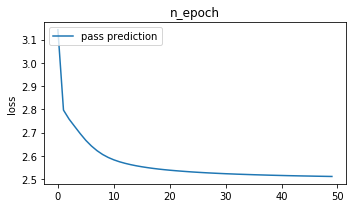

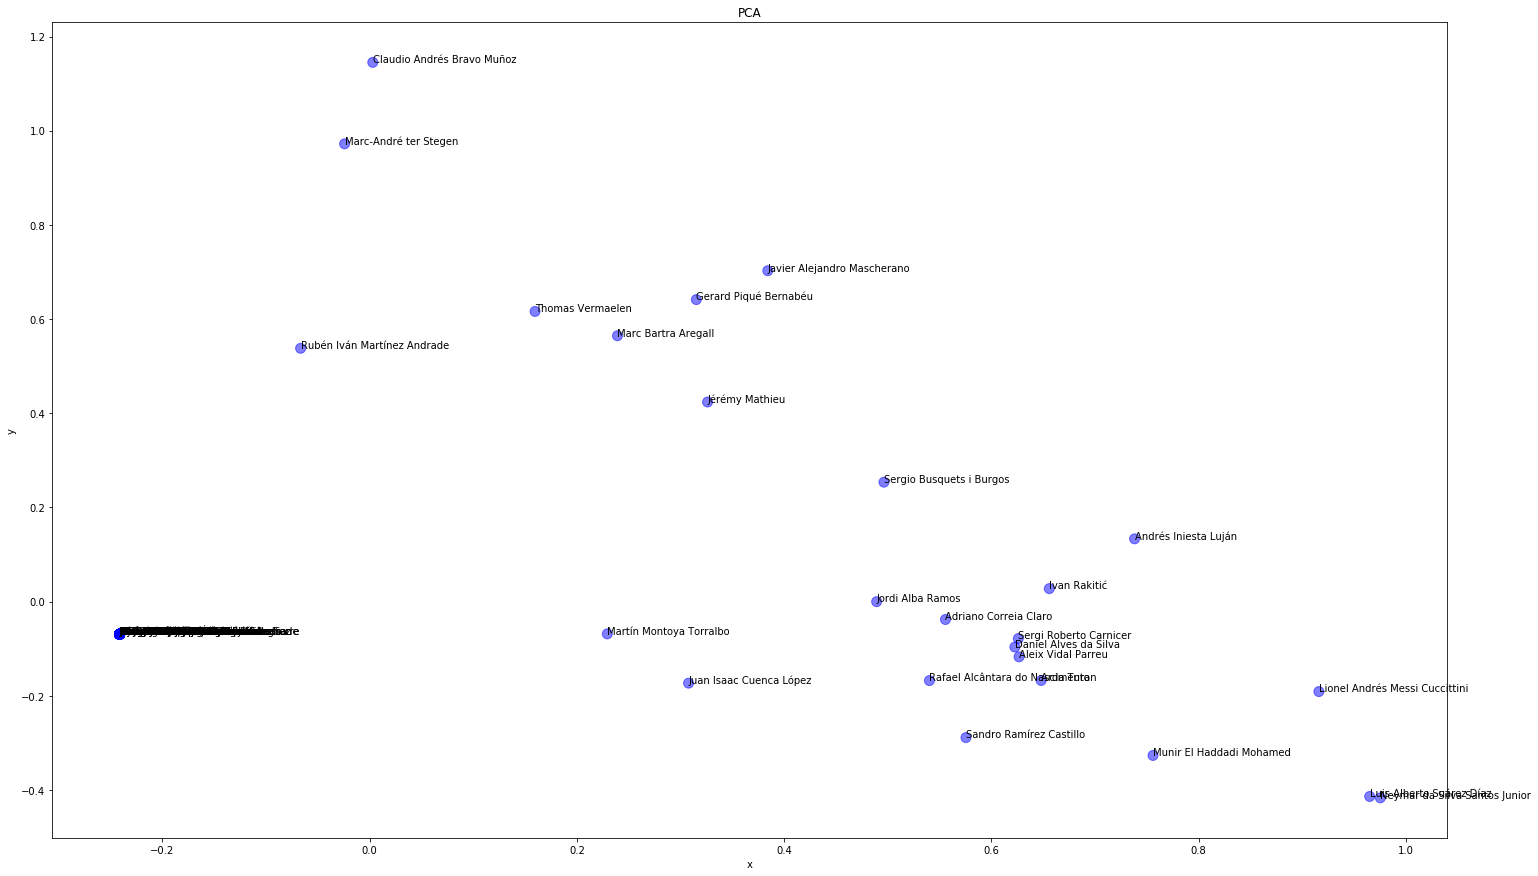

season: 2014/2015, [1] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


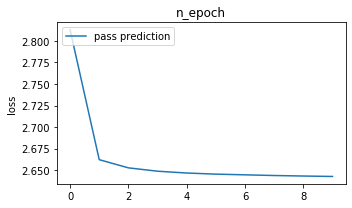

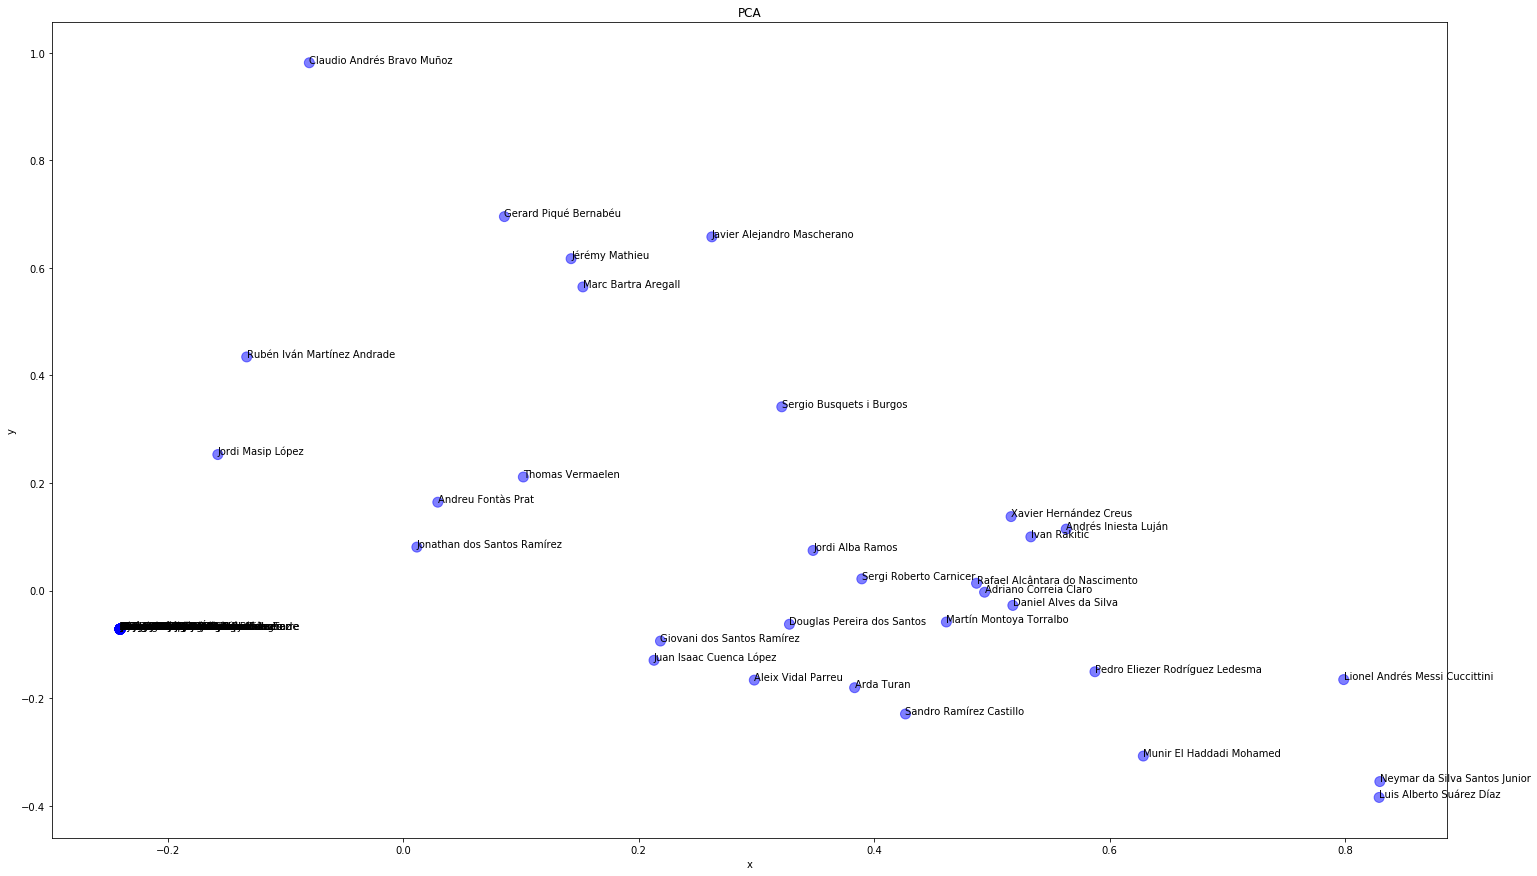

season: 2013/2014, [2] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


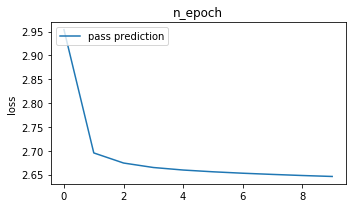

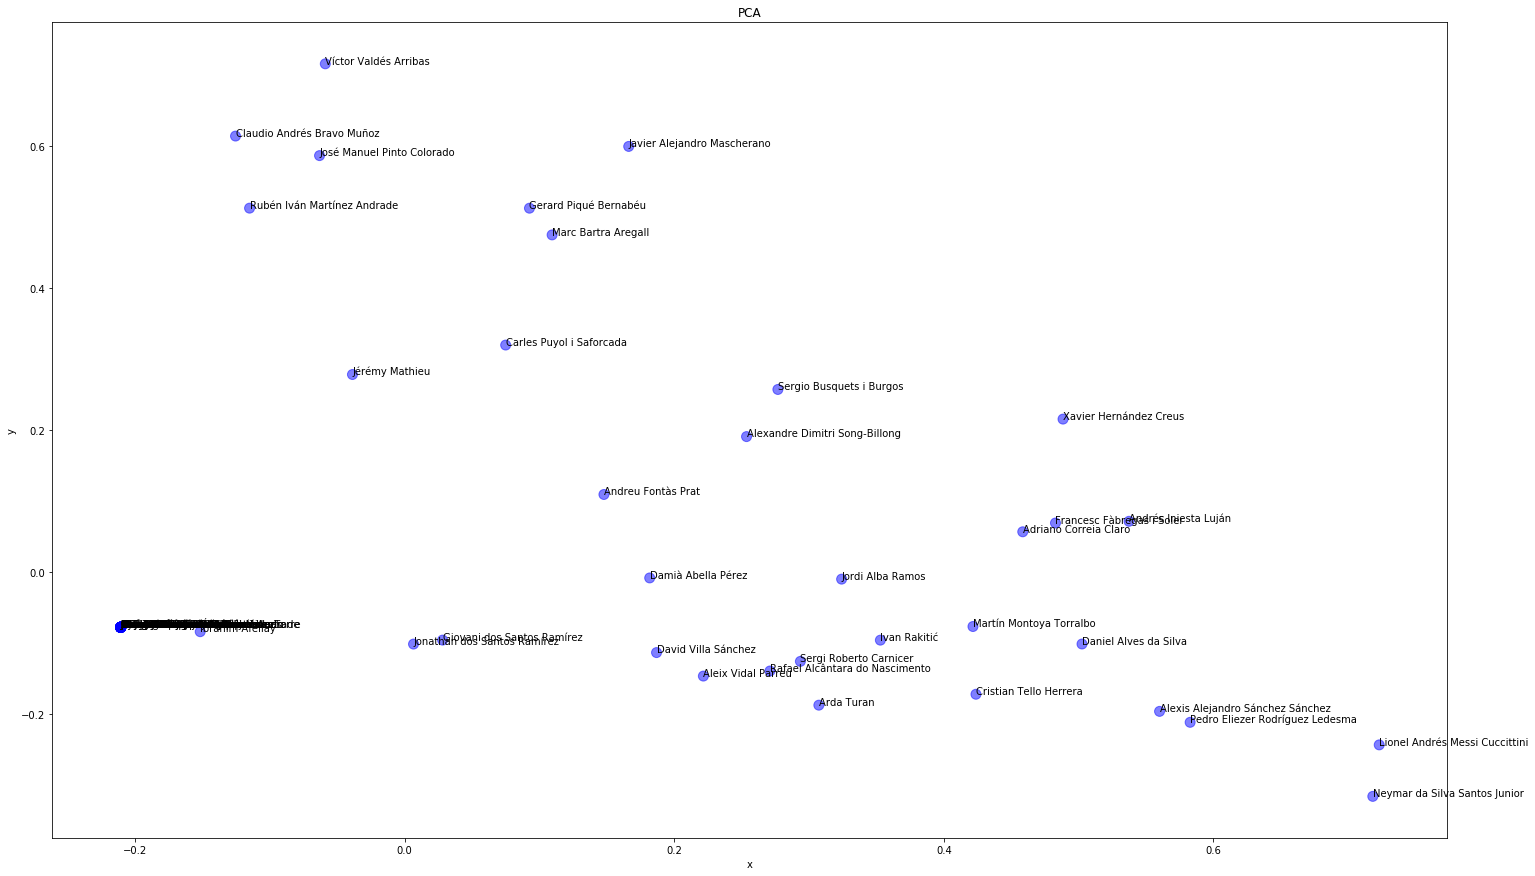

season: 2012/2013, [3] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


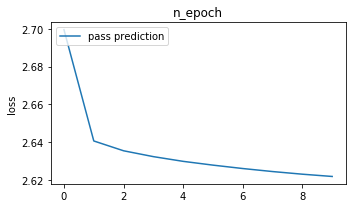

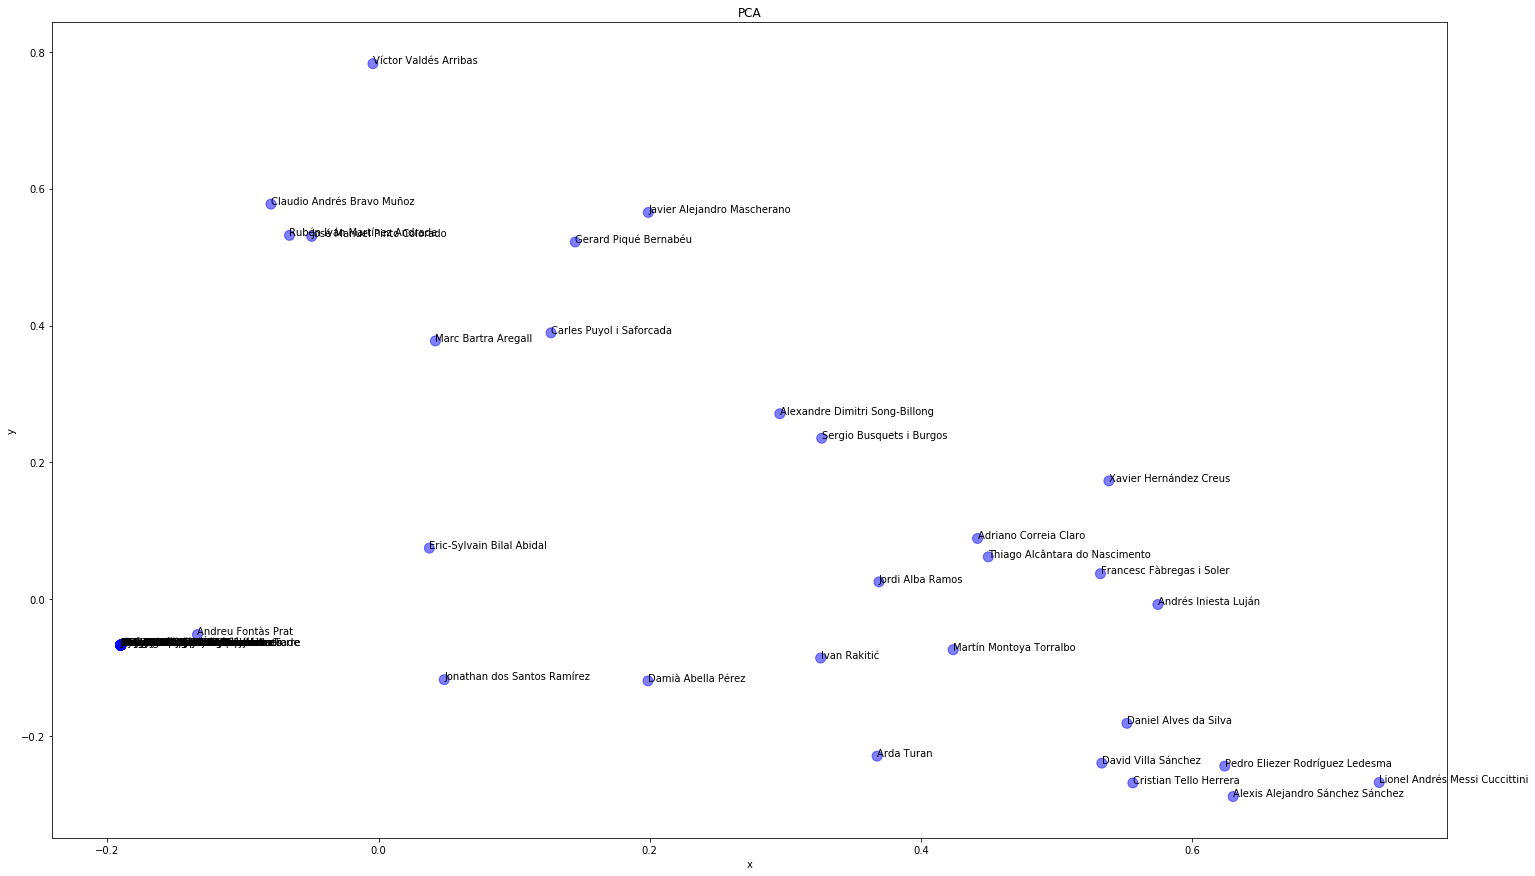

season: 2011/2012, [4] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


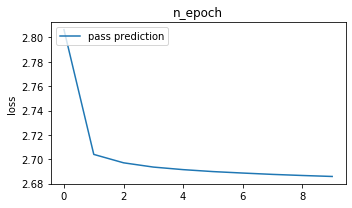

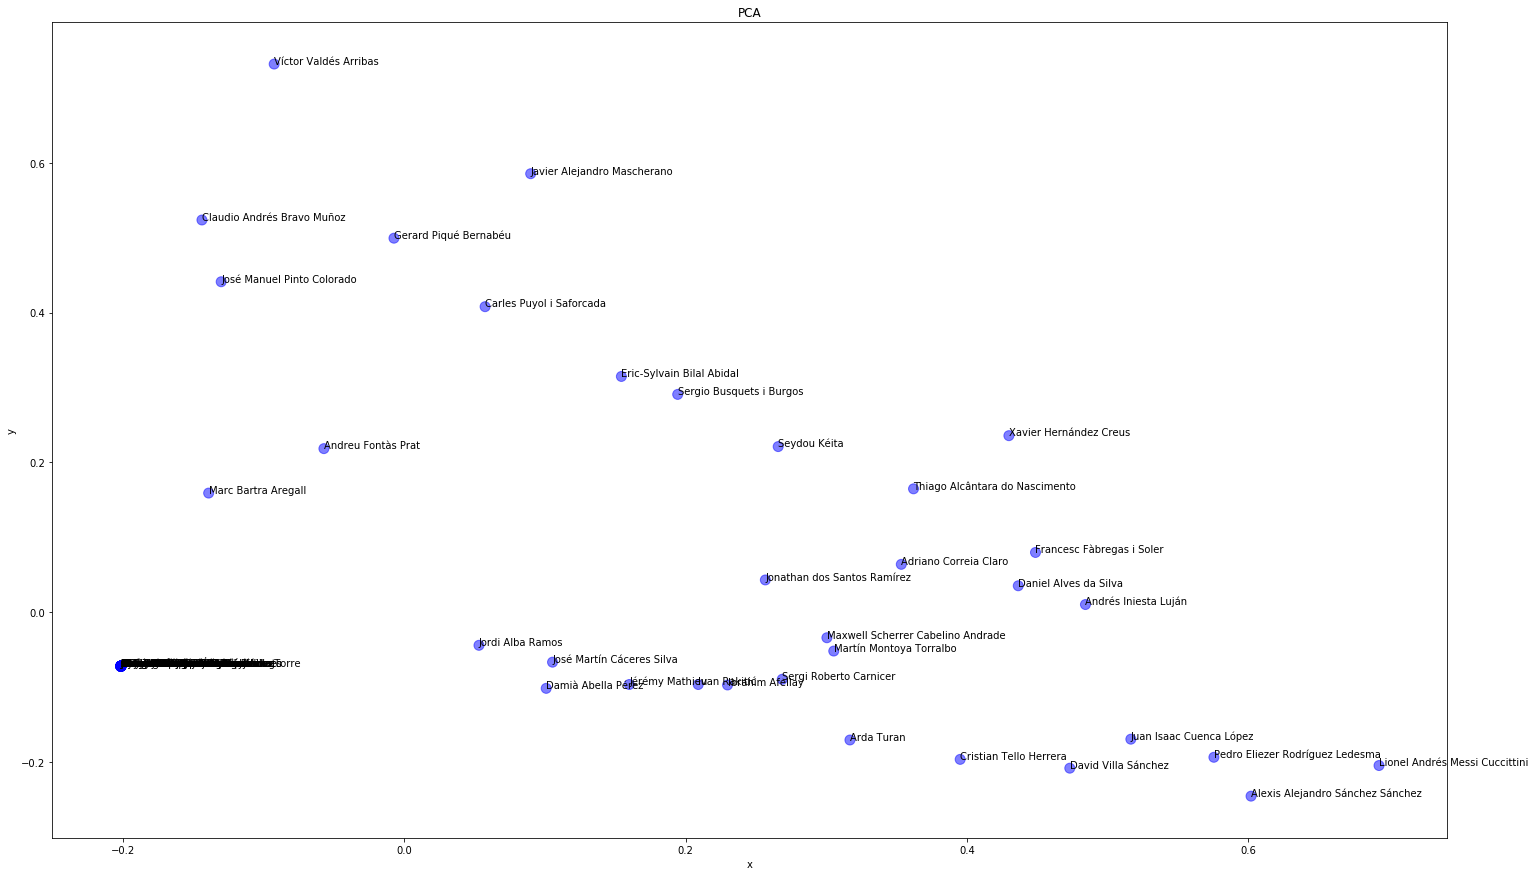

season: 2010/2011, [5] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


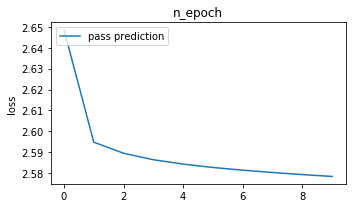

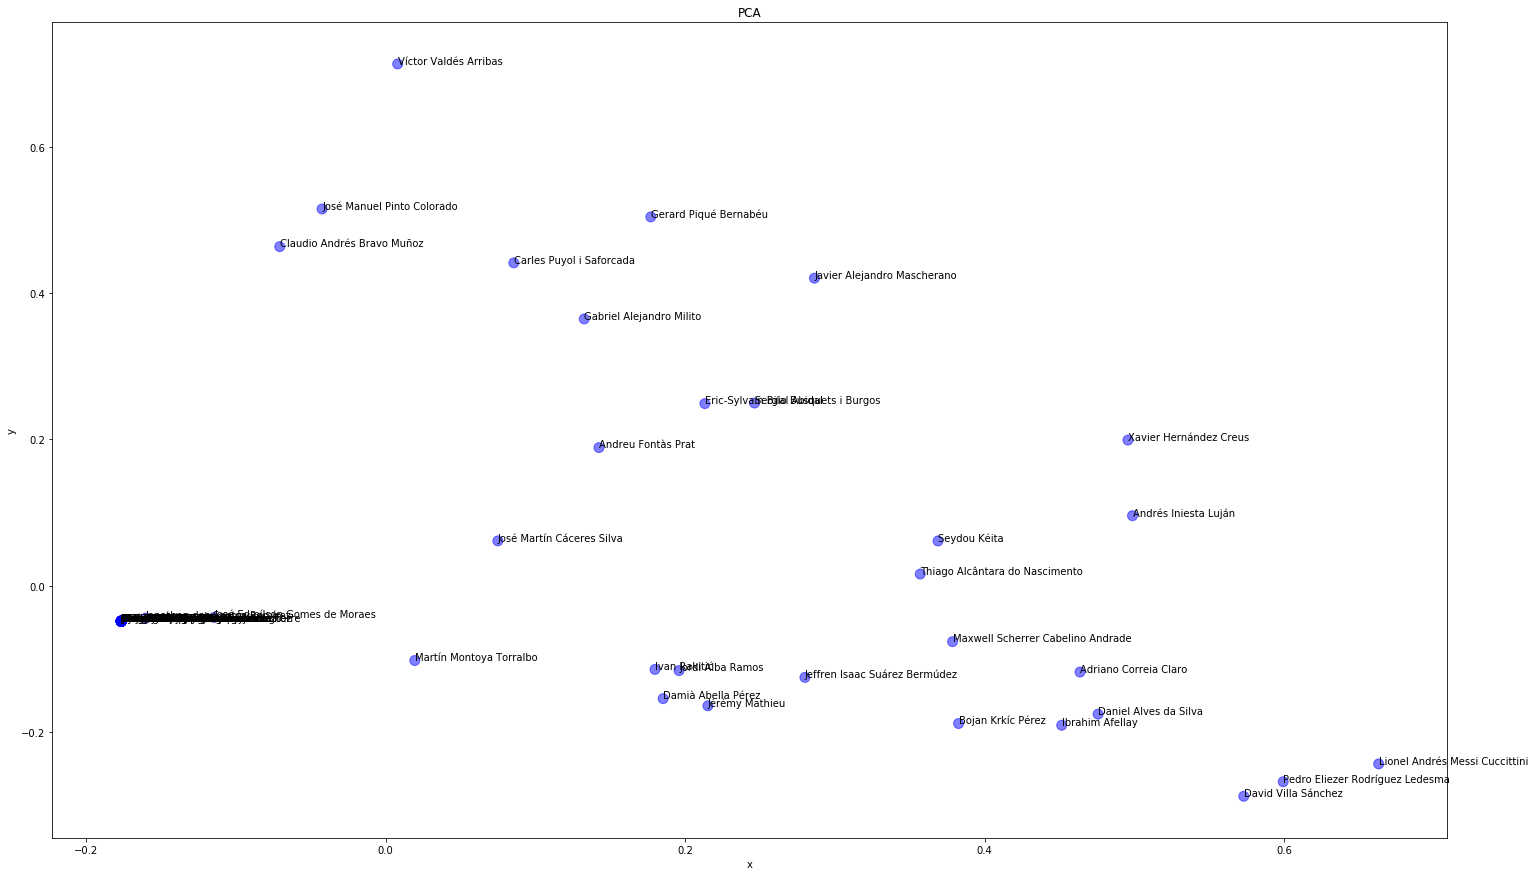

season: 2009/2010, [6] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


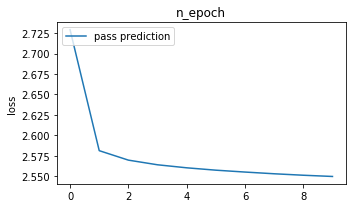

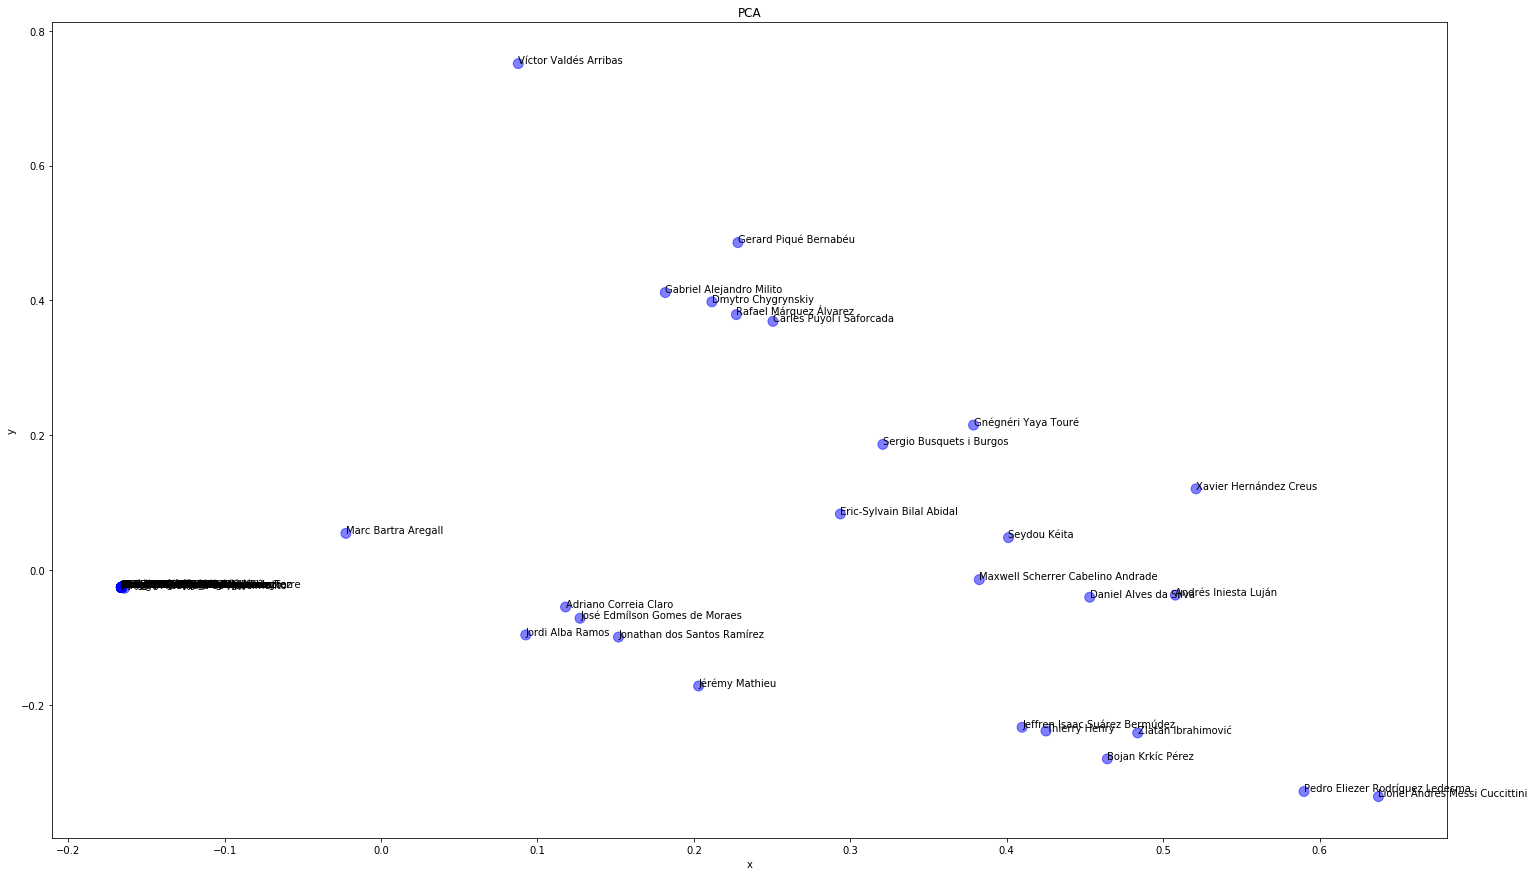

season: 2008/2009, [7] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


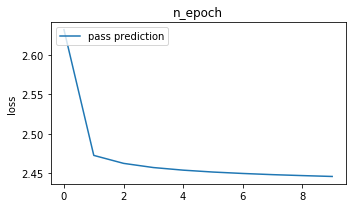

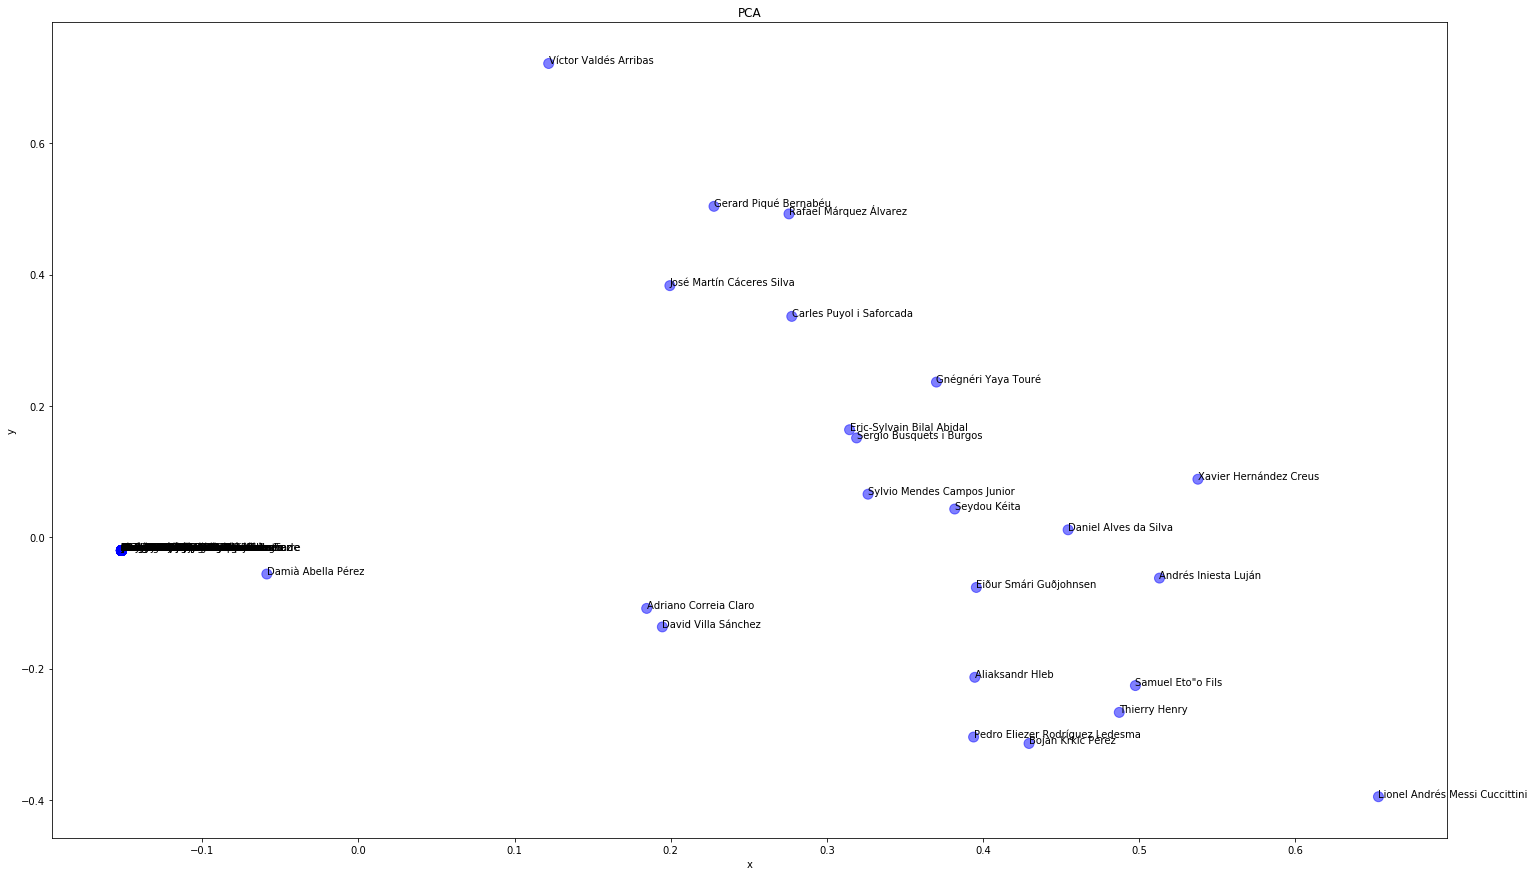

season: 2007/2008, [8] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


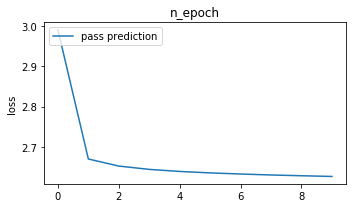

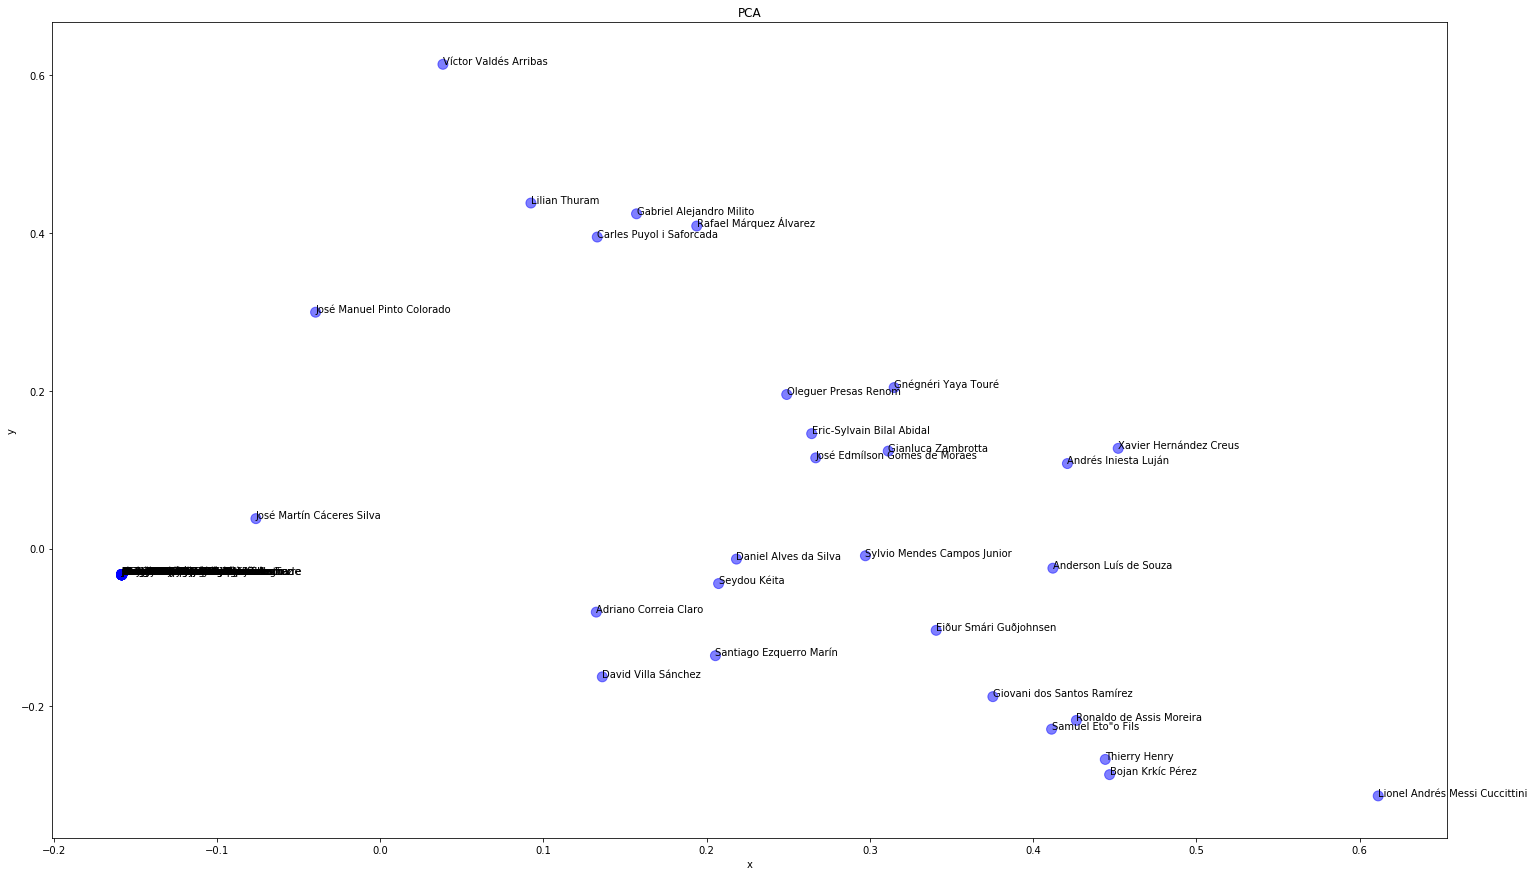

season: 2006/2007, [9] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


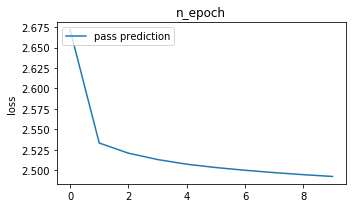

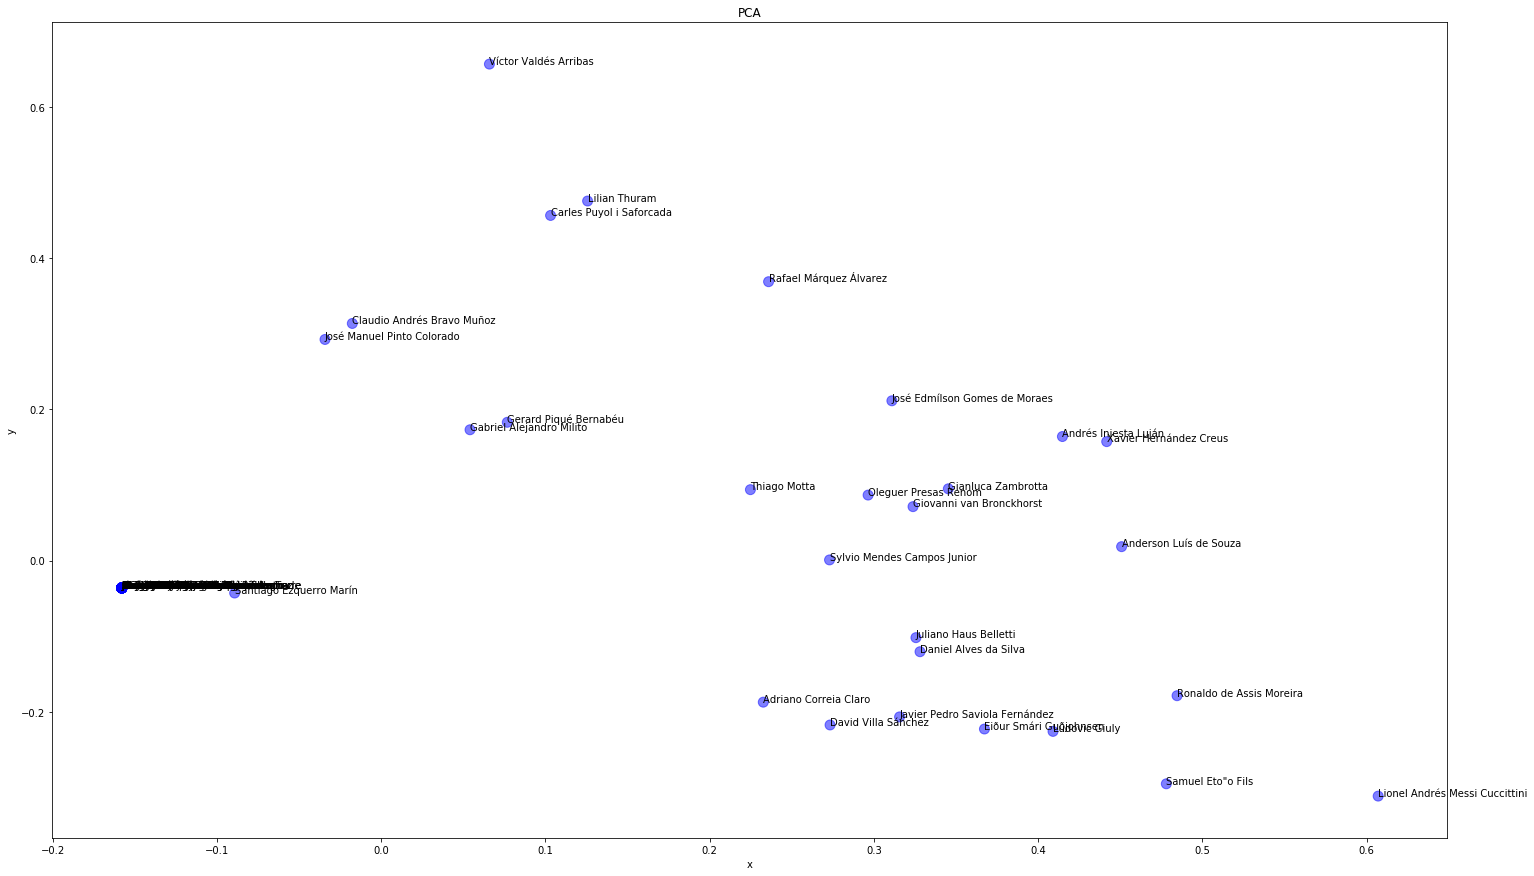

season: 2005/2006, [10] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


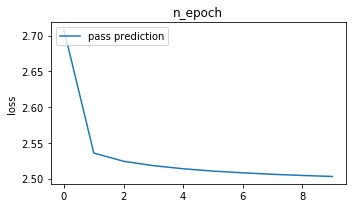

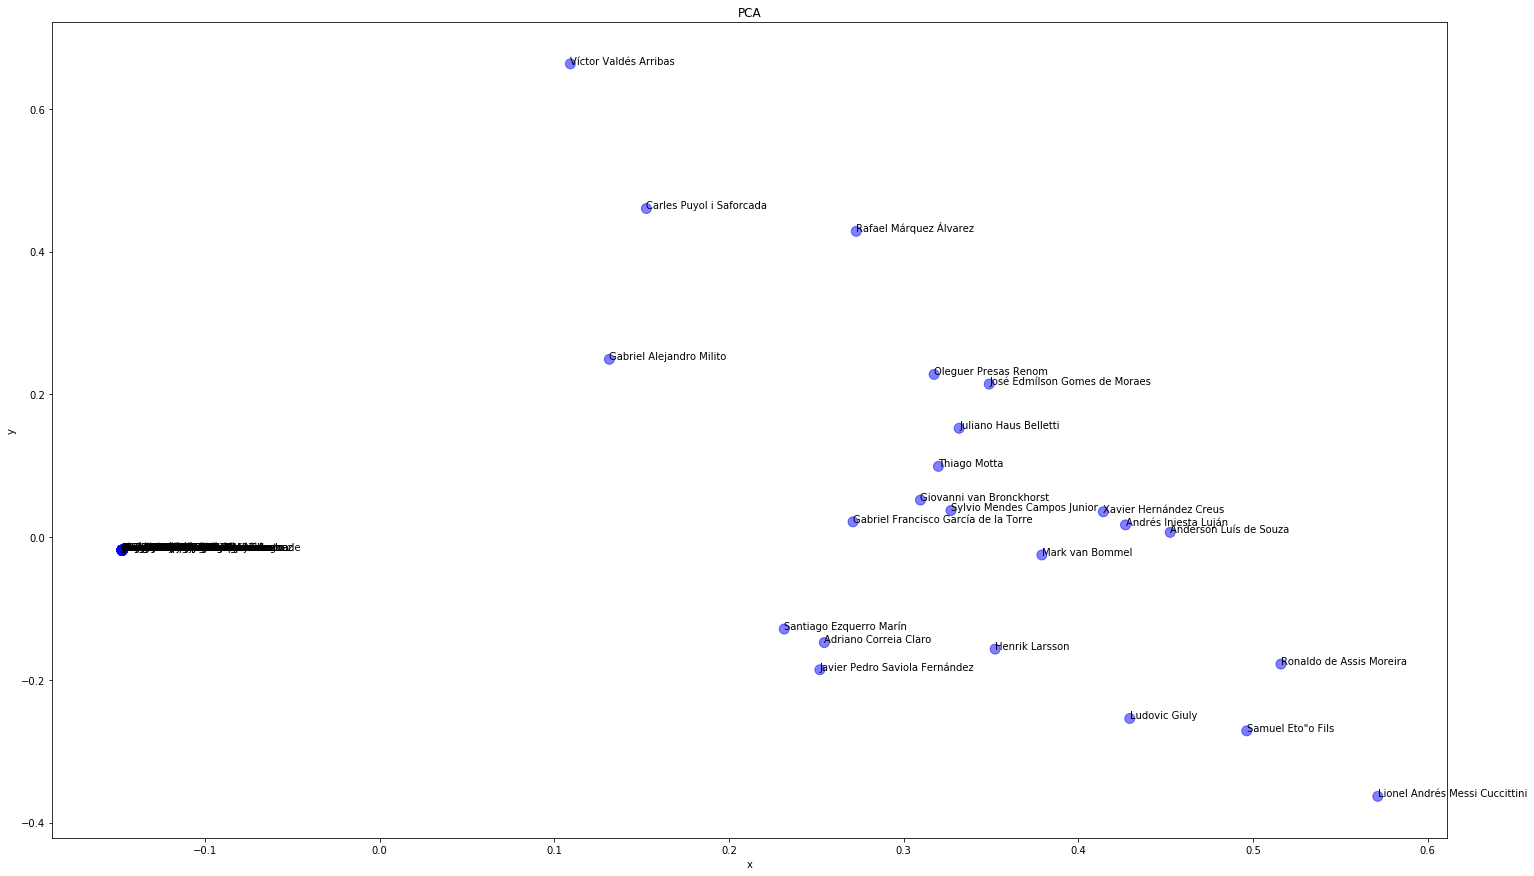

season: 2004/2005, [11] of [12]
start training...


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Pass2Vec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


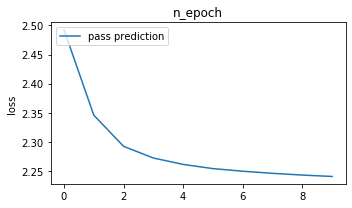

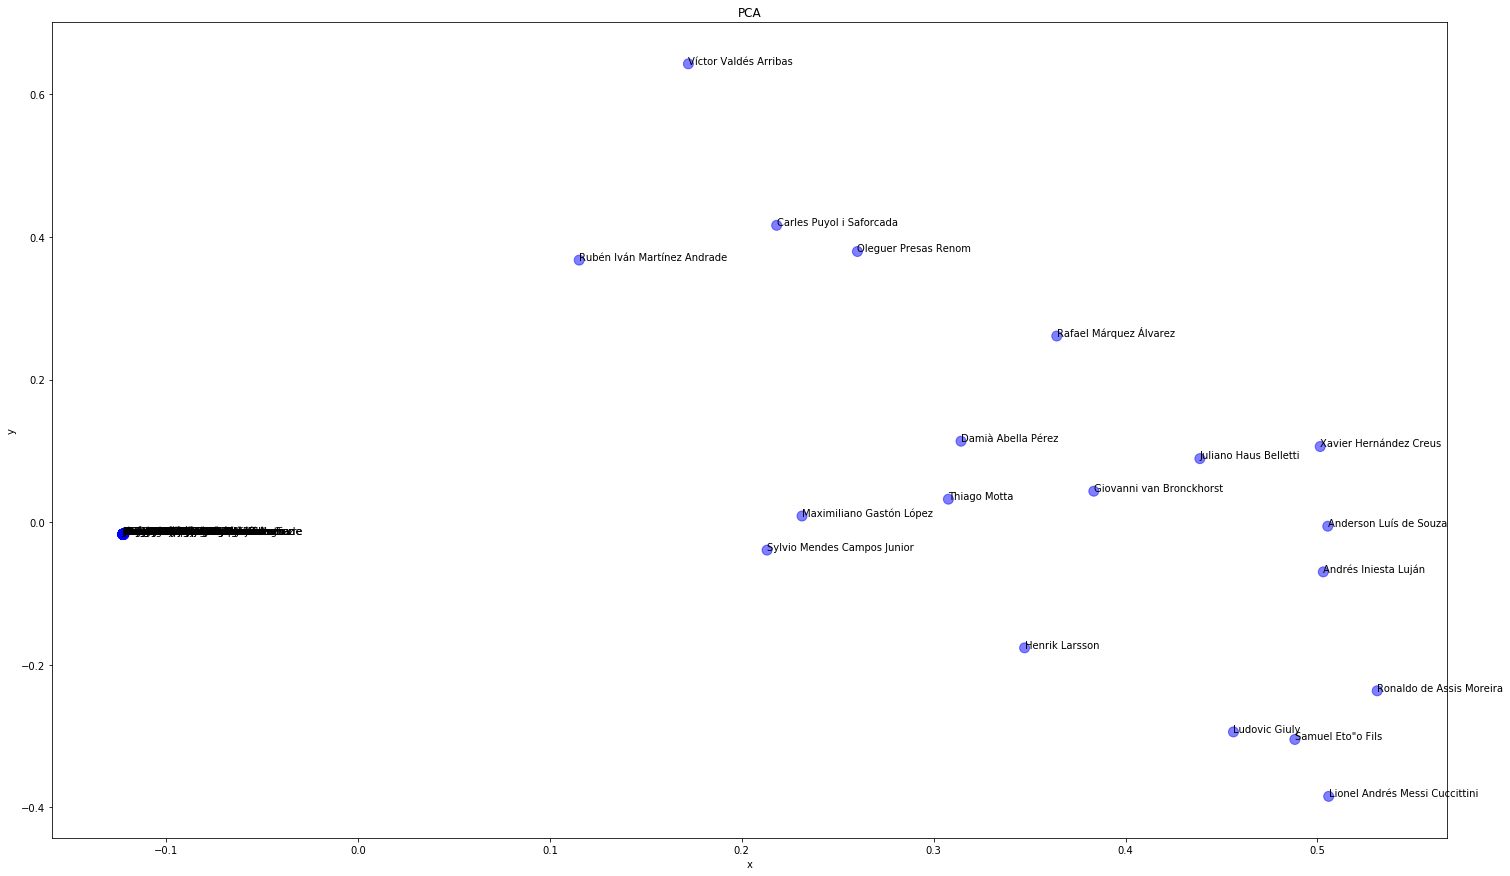

In [23]:
n_epoches = 50
for i, (season_name, matches_idx) in enumerate(matches_by_seasons[::-1]):
    print(f'season: {season_name}, [{i}] of [{len(matches_by_seasons)}]')
    data, players = create_data(matches_idx)
    data, players = afterproc_data(data, players)
    print('start training...')
    avg_loss = train(model, data, players, n_epoches)
    path = re.sub(r'/', '_', season_name)
    torch.save(model, 'models/model'+path+'.pth')
    plot_loss(avg_loss)
    emb = Embedding(model, barca_players, player2idx)
    save(emb, 'embeddings/emb'+path+'.pickle')
    vectors, pca_results = get_pca(emb)
    plot_pca(vectors, pca_results)
    n_epoches = 10

In [74]:
players_by_seasons = {}

for i, season in enumerate(tqdm(seasons)):
    players = []
    for match_id in matches_by_seasons[i][1]:
        match = sb.Events(event_id=match_id)
        j = 0 if match.data[0]['possession_team']['name'] == 'Barcelona' else 1
        players += [player['player']['name'] for player in match.data[j]['tactics']['lineup']]
    players_by_seasons[season] = list(set(players))


100%|██████████| 12/12 [04:37<00:00, 27.05s/it]

In [75]:
vecs_by_seasons = defaultdict(list)

for i, season in enumerate(seasons):
    current_emb_path = 'embeddings/emb' + re.sub(r'/', '_', season) + '.pickle'
    with open(current_emb_path, 'rb') as f:
        current_emb = pickle.load(f)
    for player in players_by_seasons[season]:
        vec = current_emb[player]
        if not vecs_by_seasons[player]:
            dat = {'season_name': season,
                   'vector': vec,
                   'distance': None}
        else:
            dt = distance.cosine(vec, vecs_by_seasons[player][-1]['vector'])
            dat = {'season_name': season,
                   'vector': vec,
                   'distance': dt}
        vecs_by_seasons[player].append(dat)

In [76]:
save(vecs_by_seasons, 'players_vecs_by_seasons.pickle')

In [77]:
weighted_dist_by_players = defaultdict(list)
for player, data in vecs_by_seasons.items():
    for data_s in data[1:]:
        weighted_dist_by_players[player].append(data_s['distance'])
weighted_dist_by_players = {key: (round(sum(val)/len(val), 5), round(sum(val), 5), len(val)) 
                            for key, val in weighted_dist_by_players.items()}

In [78]:
sorted(weighted_dist_by_players.items(), key=lambda x: -x[1][0])

[('Sergi Roberto Carnicer', (0.10884, 0.21768, 2)),
 ('Thomas Vermaelen', (0.10833, 0.10833, 1)),
 ('Oleguer Presas Renom', (0.06726, 0.20177, 3)),
 ('Juliano Haus Belletti', (0.06234, 0.12469, 2)),
 ('Andreu Fontàs Prat', (0.05069, 0.05069, 1)),
 ('José Manuel Pinto Colorado', (0.04552, 0.1821, 4)),
 ('Marc Bartra Aregall', (0.04526, 0.13577, 3)),
 ('Munir El Haddadi Mohamed', (0.04033, 0.04033, 1)),
 ('Adriano Correia Claro', (0.03958, 0.19792, 5)),
 ('Eric-Sylvain Bilal Abidal', (0.03856, 0.19282, 5)),
 ('Jérémy Mathieu', (0.03849, 0.03849, 1)),
 ('Martín Montoya Torralbo', (0.03146, 0.12583, 4)),
 ('Maxwell Scherrer Cabelino Andrade', (0.02824, 0.05648, 2)),
 ('Alexandre Dimitri Song-Billong', (0.02627, 0.02627, 1)),
 ('Ibrahim Afellay', (0.02562, 0.02562, 1)),
 ('Carles Puyol i Saforcada', (0.02483, 0.22345, 9)),
 ('Alexis Alejandro Sánchez Sánchez', (0.02366, 0.04732, 2)),
 ('Gabriel Alejandro Milito', (0.02232, 0.04464, 2)),
 ('José Edmílson Gomes de Moraes', (0.02044, 0.04088, 

In [79]:
tr = {}
for player, data in vecs_by_seasons.items():
    tr[player] = {}
    for data_s in data[1:]:
        tr[player][data_s['season_name']] = data_s['distance']

sum_dist_by_seasons = []
for i, season in enumerate(seasons[1:]):
    current_sum = 0.
    for _, data_s in tr.items():
        if season in data_s.keys():
            current_sum += data_s[season]
    sum_dist_by_seasons.append(current_sum)

In [80]:
sum_dist_by_seasons

[0.22376471757888794,
 0.25900107622146606,
 0.23908406496047974,
 0.15386658906936646,
 0.12137949466705322,
 0.30266404151916504,
 0.4465870261192322,
 0.3199261426925659,
 0.3522631525993347,
 0.42278867959976196,
 0.3771167993545532]

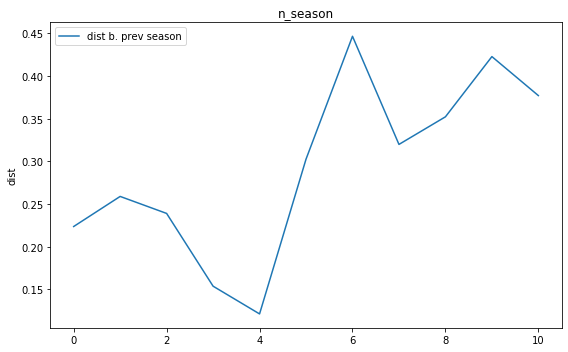

In [81]:
Xc, Yc = range(len(sum_dist_by_seasons)), sum_dist_by_seasons

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(Xc, Yc, label='dist b. prev season')
ax.set_title('n_season')
ax.legend(loc='upper left')
ax.set_ylabel('dist')
fig.tight_layout()

plt.show()

In [82]:
avg_vec_by_players = defaultdict(list)
for player, data in vecs_by_seasons.items():
    for data_s in data:
        avg_vec_by_players[player].append(data_s['vector'])
avg_vec_by_players = {key: sum(val)/len(val) 
                            for key, val in avg_vec_by_players.items()}

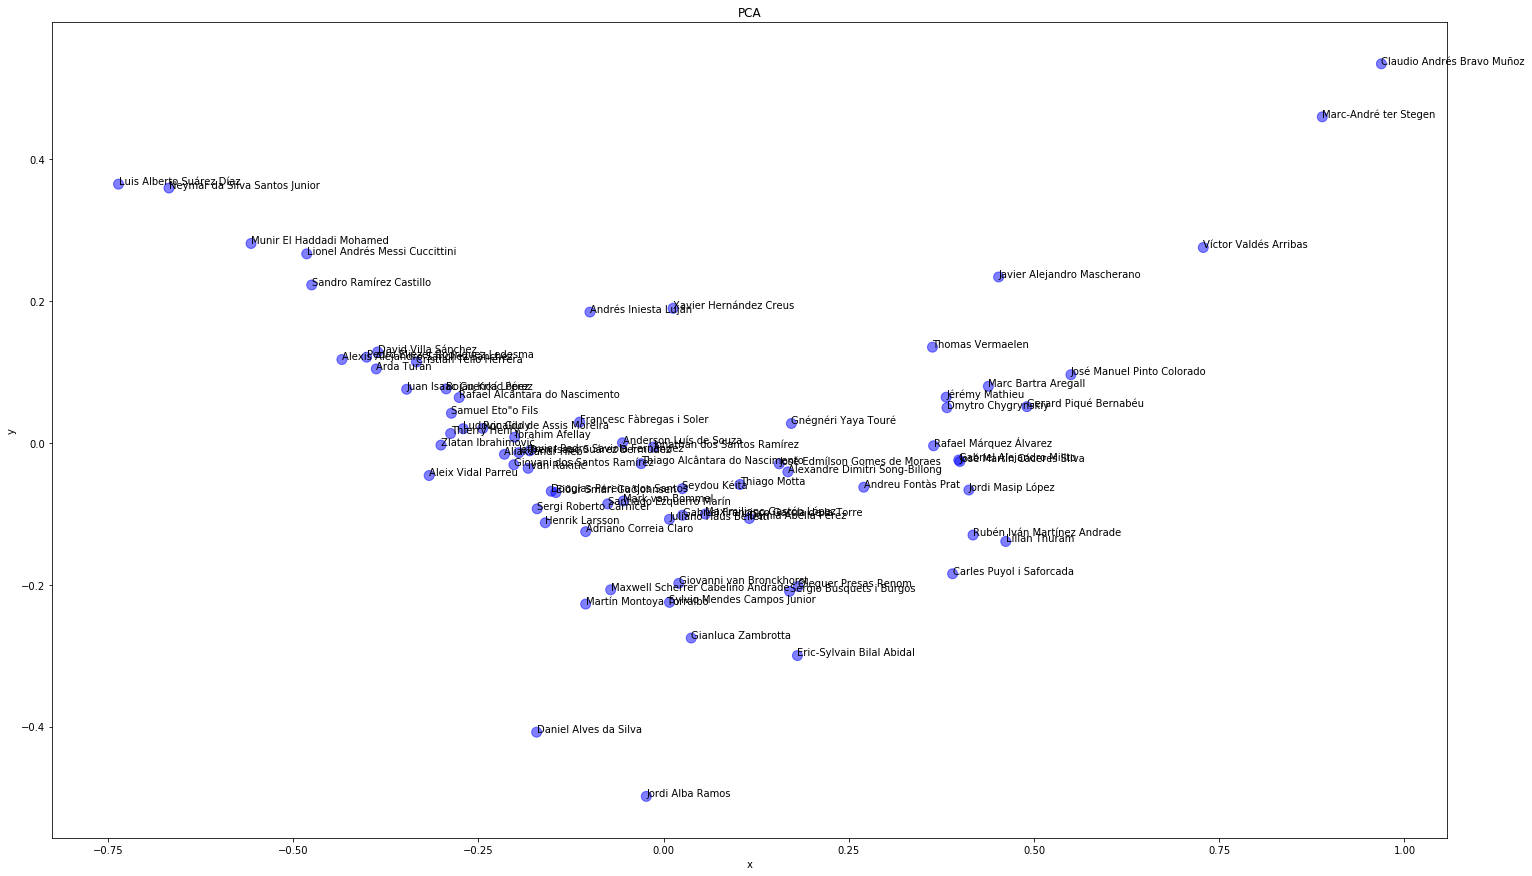

In [83]:
vecs, p_res = get_pca(avg_vec_by_players)
plot_pca(vecs, p_res)

In [96]:
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000)
vectors = [avg_vec_by_players[name] for name in barca_players]
tsne_results = tsne.fit_transform(vectors)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 75 samples in 0.000s...
[t-SNE] Computed neighbors for 75 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 0.149354
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.116997
[t-SNE] KL divergence after 1000 iterations: 0.315029


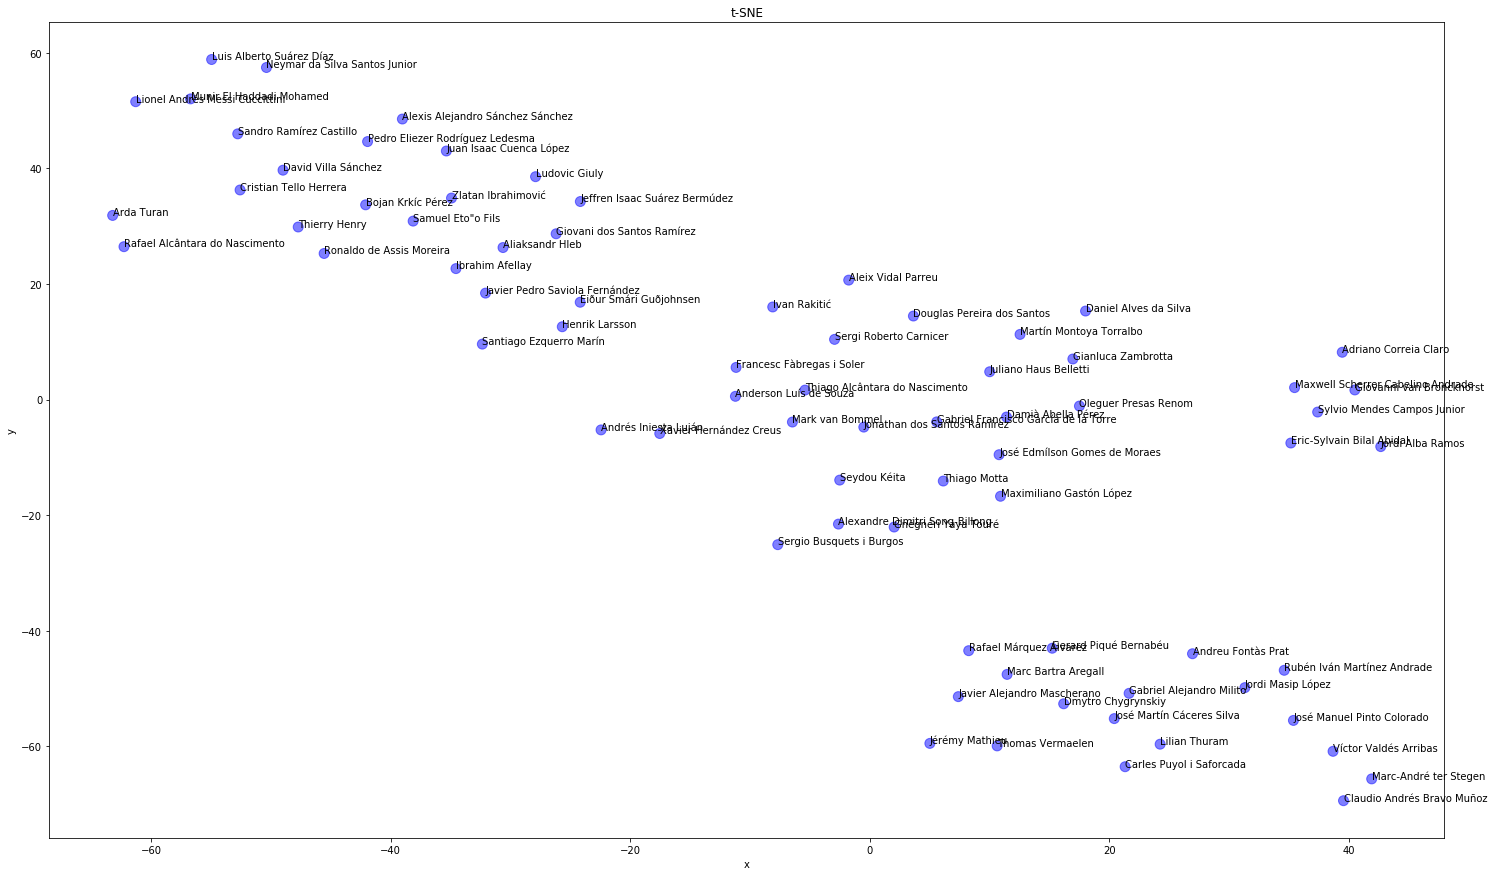

In [91]:
colors = ['b'] * len(vectors) 

fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c=colors, s=[100]*len(tsne_results))
plt.title('t-SNE')
plt.xlabel('x')
plt.ylabel('y')

for i, player in enumerate(barca_players):
    ax.annotate(player, (tsne_results[i][0], tsne_results[i][1]))

plt.show()

In [97]:
barca_players

['Víctor Valdés Arribas',
 'Juliano Haus Belletti',
 'Oleguer Presas Renom',
 'Carles Puyol i Saforcada',
 'Giovanni van Bronckhorst',
 'Rafael Márquez Álvarez',
 'Xavier Hernández Creus',
 'Anderson Luís de Souza',
 'Ludovic Giuly',
 'Ronaldo de Assis Moreira',
 'Samuel Eto"o Fils',
 'Andrés Iniesta Luján',
 'Rubén Iván Martínez Andrade',
 'Damià Abella Pérez',
 'Henrik Larsson',
 'Maximiliano Gastón López',
 'José Edmílson Gomes de Moraes',
 'Lionel Andrés Messi Cuccittini',
 'Sylvio Mendes Campos Junior',
 'Mark van Bommel',
 'Thiago Motta',
 'Gabriel Francisco García de la Torre',
 'Gianluca Zambrotta',
 'Lilian Thuram',
 'Eiður Smári Guðjohnsen',
 'Javier Pedro Saviola Fernández',
 'Gabriel Alejandro Milito',
 'Eric-Sylvain Bilal Abidal',
 'Thierry Henry',
 'Bojan Krkíc Pérez',
 'Gnégnéri Yaya Touré',
 'Giovani dos Santos Ramírez',
 'Santiago Ezquerro Marín',
 'José Manuel Pinto Colorado',
 'Daniel Alves da Silva',
 'Sergio Busquets i Burgos',
 'Seydou Kéita',
 'Gerard Piqué Berna

In [108]:
key_players = ['Xavier Hernández Creus', 'Andrés Iniesta Luján', 'Thiago Motta', 
               'Sergio Busquets i Burgos', 'Daniel Alves da Silva' 
               'Thiago Alcântara do Nascimento', 
               'Alexis Alejandro Sánchez Sánchez', #'Francesc Fàbregas i Soler', 
               'Neymar da Silva Santos Junior', 
               'Luis Alberto Suárez Díaz', #'Thomas Vermaelen', 
               'Lionel Andrés Messi Cuccittini']
named_vecs = []
for player in key_players:
    for data_s in vecs_by_seasons[player]:
        named_vecs.append((player+' '+data_s['season_name'], data_s['vector']))

In [109]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform([x[1] for x in named_vecs])

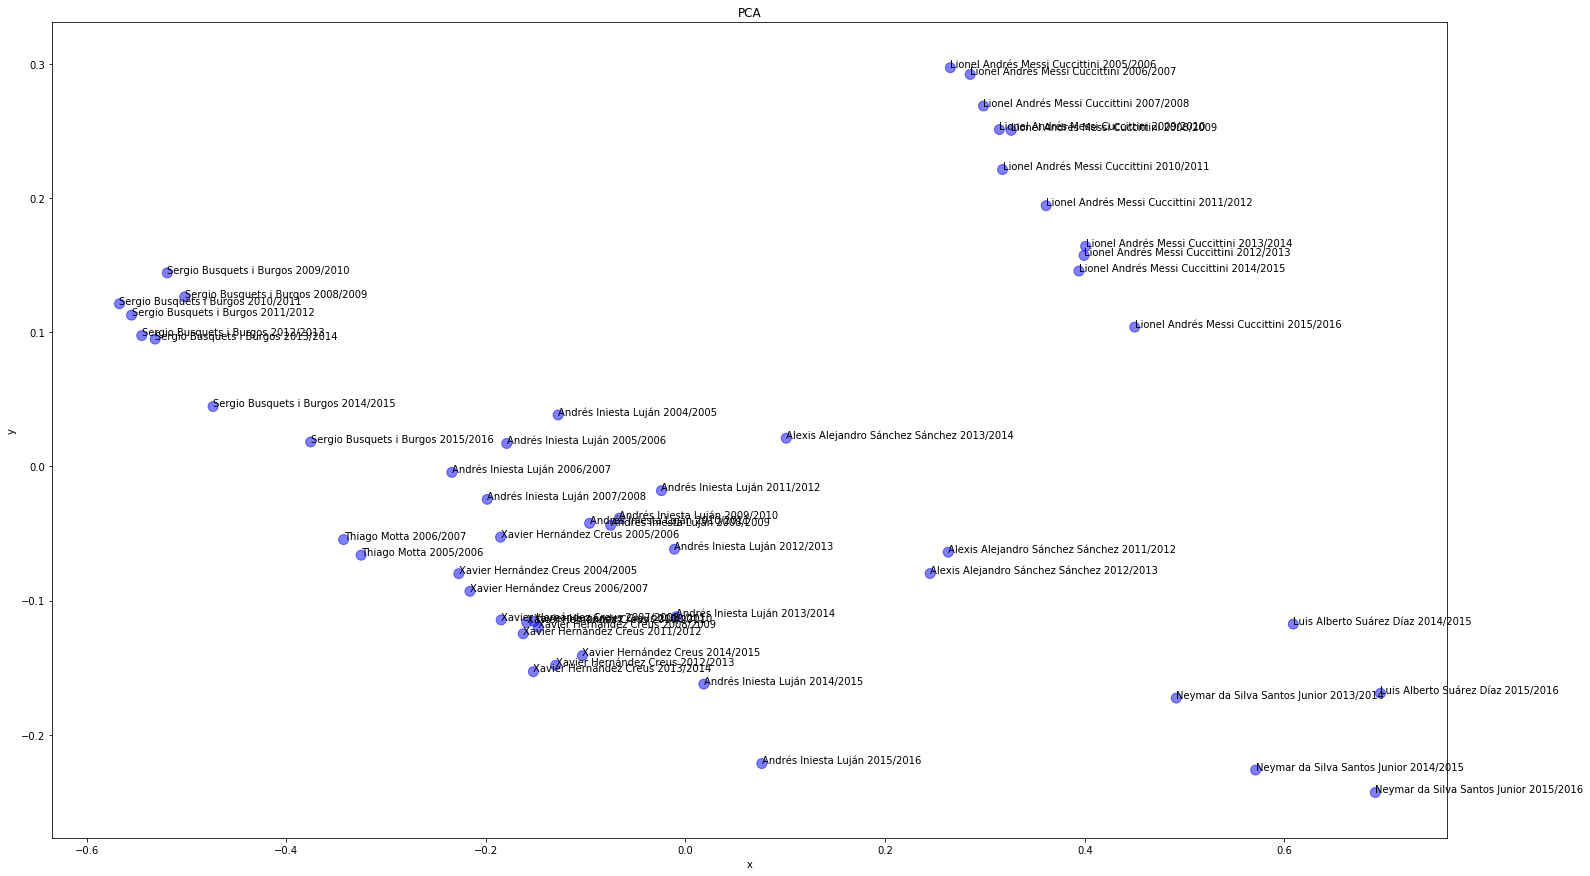

In [110]:
colors = ['b'] * len(named_vecs) 

fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, c=colors, s=[100]*len(pca_results))
plt.title('PCA')
plt.xlabel('x')
plt.ylabel('y')

for i, (player, _) in enumerate(named_vecs):
    ax.annotate(player, (pca_results[i][0], pca_results[i][1]))

plt.show()

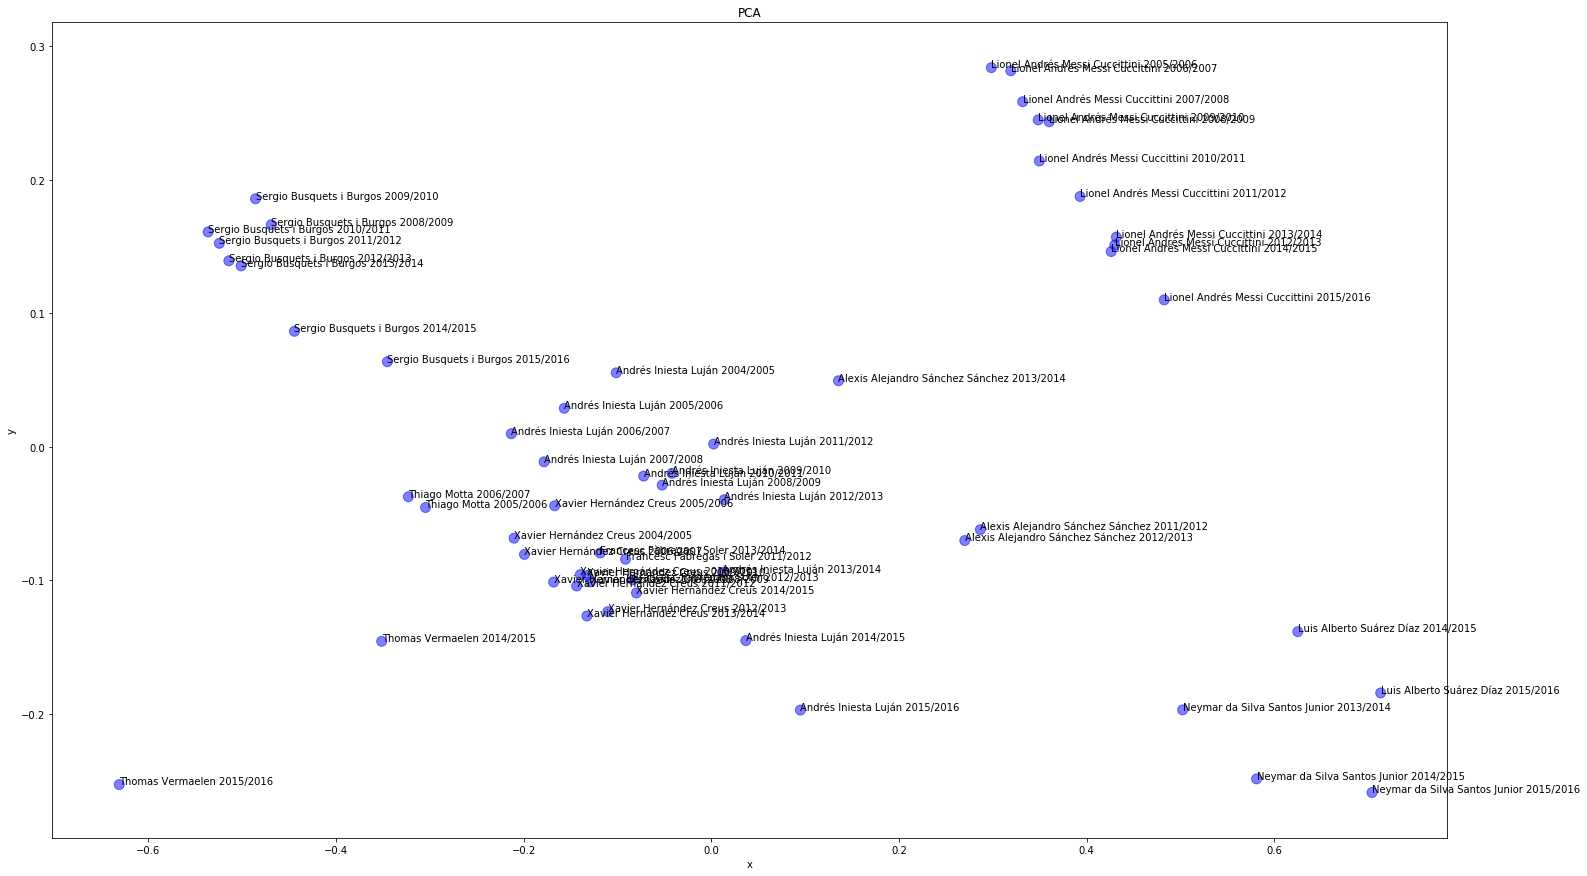

In [107]:
colors = ['b'] * len(named_vecs) 

fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, c=colors, s=[100]*len(pca_results))
plt.title('PCA')
plt.xlabel('x')
plt.ylabel('y')

for i, (player, _) in enumerate(named_vecs):
    ax.annotate(player, (pca_results[i][0], pca_results[i][1]))

plt.show()

In [111]:
seasons

['2004/2005',
 '2005/2006',
 '2006/2007',
 '2007/2008',
 '2008/2009',
 '2009/2010',
 '2010/2011',
 '2011/2012',
 '2012/2013',
 '2013/2014',
 '2014/2015',
 '2015/2016']

In [113]:
managers = {'Frank Rijkaard': ['2004/2005', '2005/2006', '2006/2007', '2007/2008'],
            'Pep Guardiola': ['2008/2009', '2009/2010', '2010/2011'],
            'Tito Vilanova': ['2012/2013'],
            'Gerardo Martino': ['2013/2014'],
            'Luis Enrique': ['2014/2015', '2015/2016']}

In [119]:
tr = {}
for player, data in vecs_by_seasons.items():
    tr[player] = {}
    for data_s in data:
        tr[player][data_s['season_name']] = data_s['vector']

team_vecs = {}
for manager, list_season in managers.items():
    for season in list_season:
        vec = np.zeros(16)
        for player in players_by_seasons[season]:
            vec += tr[player][season]
        vec /= len(players_by_seasons[season])
        team_vecs[manager + ' ' + season] = vec

In [122]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform([x[1] for x in team_vecs.items()])

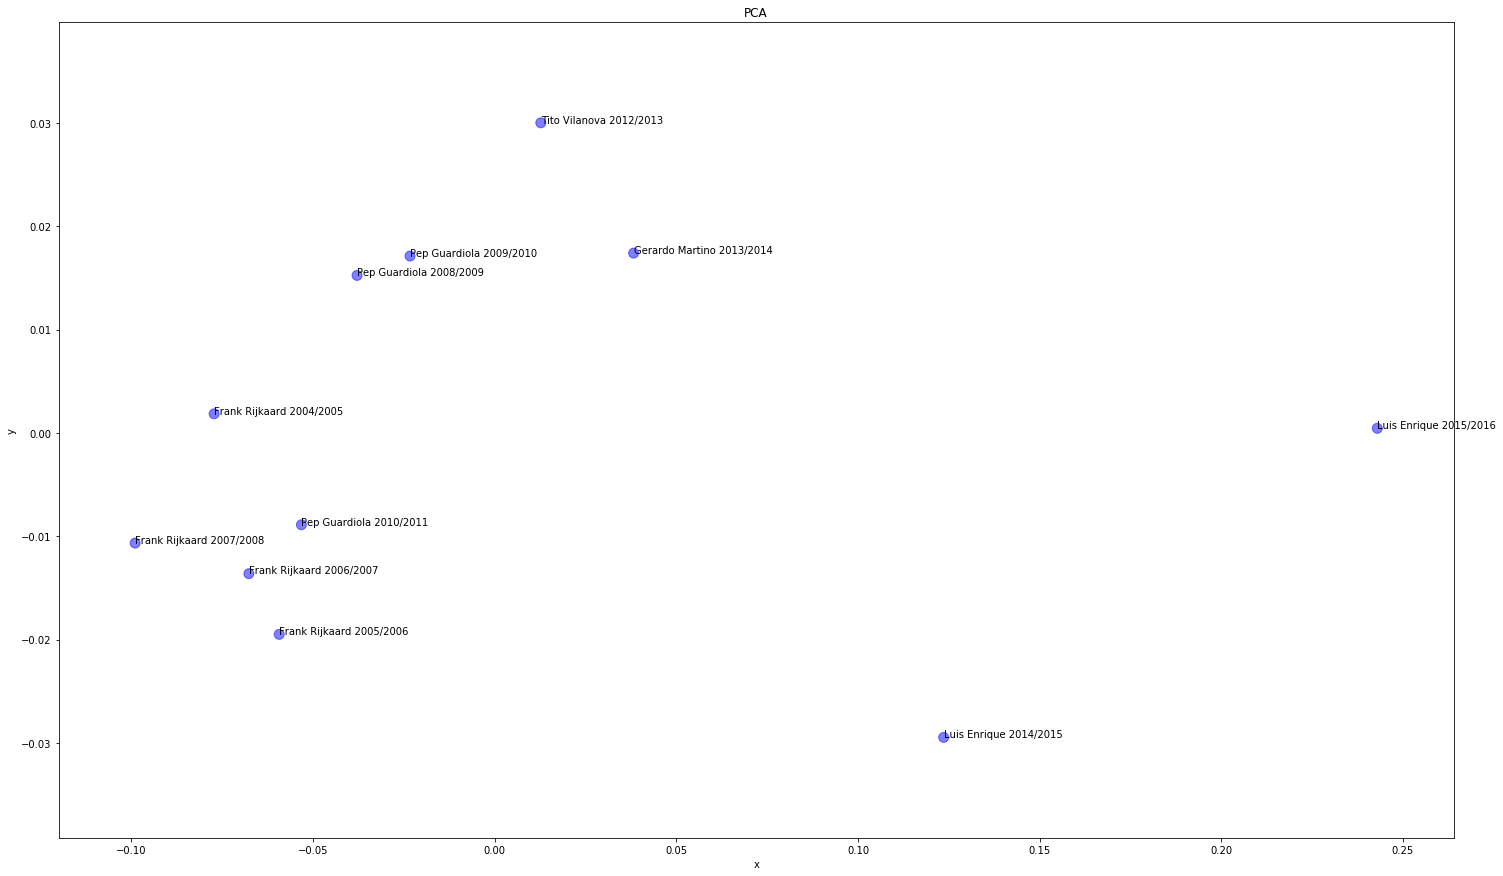

In [125]:
colors = ['b'] * len(list(team_vecs.items()))

fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, c=colors, s=[100]*len(pca_results))
plt.title('PCA')
plt.xlabel('x')
plt.ylabel('y')

for i, manager in enumerate([x[0] for x in team_vecs.items()]):
    ax.annotate(manager, (pca_results[i][0], pca_results[i][1]))

plt.show()